In [1]:
# This file is subject to the terms and conditions defined in file
# `COPYING.md`, which is part of this source code package.

import os
from classifiers.spectral_classifier import CPURFClassifier as classifier
from reader import LOReader
from classifiers.helpers import get_spectra_from_mask, draw_detections
import numpy as np

from lo.data.tools import LOJSONDataset
from classifiers.spectral_classifier import CPURFClassifier as classifier
from run_rgb_detection import get_from_huggingface_model
from classifiers.spectral_classifier import CPURFClassifier as classifier
from classifiers.helpers import get_spectra_from_mask, draw_detections
from classifiers.fastsam.model import FastSAM
from matplotlib import pyplot as plt
import time
from IPython.display import clear_output



In [2]:
%matplotlib inline

In [3]:
# Methods

def label_fn(ann):
    """
    Generate a class label string from the metadata of an annotation
    Args:
        ann (lo.data.tools.tools.Annotation):

    Returns:
        label (str): the class label for the annotation
    """
    return ann.class_name


### Download the training dataset

In [ ]:
from huggingface_hub import hf_hub_download

dataset_path = hf_hub_download(repo_id="LivingOptics/hyperspectral-fruit", filename='train', repo_type="dataset")
demo_data_path = hf_hub_download(repo_id="LivingOptics/hyperspectral-fruit", filename='demo-videos', repo_type="dataset")

In [7]:
# Path to save classifier post training
model_path = './fruit_classifier'

### Train the spectral classifier

In [6]:
# Load dataset in JSON format
dataset = LOJSONDataset(dataset_path)
training_data = dataset.load("train")

if not os.path.exists(model_path):
    os.makedirs(model_path)

# Instantiate Classifier
model = classifier(
    classifier_path=model_path,
    plot_spectra=False,
    do_reflectance=True,
)

print("Starting training")
model.train(
    training_data,
    erode_dilate=True,
    iterations=1,
    label_generator_fn=label_fn,
    include_background_in_training=True,
    n_estimators=60
)

# Print class labels
for k, v in classifier.metadata.items():
    print(k, v[0])

Starting training
Warm starting classifier
	Loading training data
	Data loaded in 8.00 seconds
	Fitting classifier on 85499 positive and 347070 negative spectral samples 
	Classifier trained in 787.51 seconds - saving artefacts
Training Accuracy: 100.00%


In [6]:
calibration = None # if your running on a LO orin then use '/datastore/lo/share/calibrations/latest_calibration'
source = os.path.join(demo_data_path,'melons-lemons-peppers.lo') # None for streaming 
calibration_file_path = None 

## Run segmentation enhanced with spectral classification

This inference example demonstrates a simple integration between the YOLO SAM model and a spectral classifier to achieve subclass classification and improved recognition while preserving the semantic understanding of the model.



0: 416x480 12 objects, 283.5ms
Speed: 1.3ms preprocess, 283.5ms inference, 13.2ms postprocess per image at shape (1, 3, 416, 480)


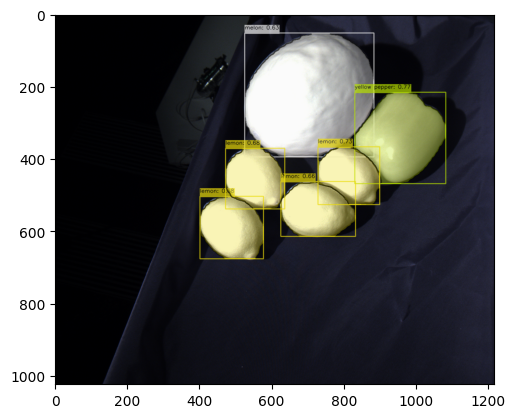

In [8]:
reader = LOReader(calibration, source, calibration_frame=calibration_file_path)

reader.source.frame_rate = int(10000e3)  # μhz
reader.source.exposure = int(100000e3)  # μs
reader.source.gain = 100


# Load trained spectral classifier
spectral_classifier = classifier(
    classifier_path=model_path,
    plot_spectra=False,
    do_reflectance=True,
)

prob_thresh = 0.4

# load segment anything model developed by ultralytics.
model = FastSAM('FastSAM-x.pt') 
plt.figure()

count = 0
while True:

        info, scene_frame, spectra = reader.get_next_frame()
        
        if scene_frame is None or count == 35:
            break

        clear_output()
        
        scene_frame = np.ascontiguousarray(scene_frame)

        results = model(scene_frame, device='cpu', retina_masks=True, imgsz=480, conf=0.6, iou=0.9)
        masks = results[0].masks.data.detach().cpu().numpy()
        segs = results[0].masks.xy
        boxes = results[0].boxes.data.detach().cpu().numpy()

        # convert from (left, top, right, bottom) to (left, right, width, height)


        metadata_out, classes, probs = spectral_classifier(
            (info, scene_frame, spectra), confidence=prob_thresh
        )
        
        
        classifier_output, _ = spectral_classifier.visualise((info, scene_frame, spectra), metadata_out)

        # assign classes to objects identify by segment anything
        for bbox, mask, seg in zip(boxes, masks, segs):
            bb_probs = get_spectra_from_mask(probs, info.sampling_coordinates, mask)
            bb_class = np.argmax(np.median(bb_probs, 0))
            if bb_class == 0:
                continue
            bb_prob = bb_probs[:,bb_class].mean(0)
            if bb_prob < prob_thresh:
                continue
            scene_frame = draw_detections(spectral_classifier.classes, scene_frame, bbox, bb_prob, bb_class, seg)
        count += 1
        plt.imshow(scene_frame)
        plt.show()
        time.sleep(0.2)
        
        

## Run vanila YOLO segmentation model:

This inference example shows a visualisation of the performance of a pretrained YOLOv8, for performance comparison purposes.



0: 544x640 2 sports balls, 319.7ms
Speed: 1.9ms preprocess, 319.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


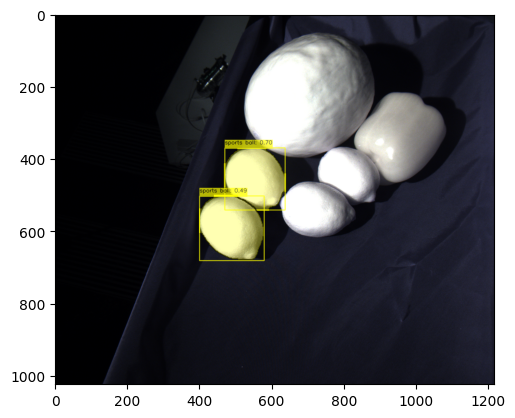

In [9]:
#Run model

# Initialise LO reader
reader = LOReader(calibration, source, calibration_frame=calibration_file_path)

reader.source.frame_rate = int(10000e3)  # μhz
reader.source.exposure = int(100000e3)  # μs
reader.source.gain = 100

model = get_from_huggingface_model(model_path='yolov8l-seg.pt')
plt.figure()
count = 0
while True:

        info, scene_frame, spectra = reader.get_next_frame()

        if scene_frame is None or count == 35:
            break
        
        clear_output()
        scene_frame = np.ascontiguousarray(scene_frame)

        
        results = model(scene_frame, imgsz=640, conf=0.2, iou=0.4)
        segments = results[0].masks.xy
        boxes = results[0].boxes.data.detach().cpu().numpy()
        for ((*box, conf, cls_), segment) in zip(boxes, segments):
            scene_frame = draw_detections(results[0].names, scene_frame, box, conf, cls_, segment)

        count += 1
        plt.imshow(scene_frame)
        plt.show()